In [1]:
!pip install tensorflow
!pip install keras

In [2]:
import os
import shutil
from shutil import copyfile 

In [31]:
import sys
for p in sys.path:
    print(p)

C:\Users\Mahima\Desktop\University\UNT\Machine Learning
C:\Users\Mahima\anaconda3\python38.zip
C:\Users\Mahima\anaconda3\DLLs
C:\Users\Mahima\anaconda3\lib
C:\Users\Mahima\anaconda3

C:\Users\Mahima\anaconda3\lib\site-packages
C:\Users\Mahima\anaconda3\lib\site-packages\win32
C:\Users\Mahima\anaconda3\lib\site-packages\win32\lib
C:\Users\Mahima\anaconda3\lib\site-packages\Pythonwin
C:\Users\Mahima\anaconda3\lib\site-packages\IPython\extensions
C:\Users\Mahima\.ipython


In [8]:
# This Directory have all the labelled images
base_dir = './dogs-vs-cats/train/train'


# Directories for our training, validation

def make_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory) 

#train_dir = os.path.join(base_dir, 'training')
#make_dir(train_dir)
#validation_dir = os.path.join('/content/dogs-vs-cats/train', 'validation')
#make_dir(validation_dir)


In [5]:
base_dir

'./dogs-vs-cats/train'

In [9]:
#splitting cats and dogs images for training and validation data
train_dir ='./dogs-vs-cats/catsvsdogs/train'
valida_dir ='./dogs-vs-cats/catsvsdogs/validation'



# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
#make_dir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
#make_dir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(valida_dir, 'cats')
#make_dir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(valida_dir, 'dogs')
#make_dir(validation_dogs_dir)

# Copy first 10000 cat images to train_cats_dir
train_cats_fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in train_cats_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    copyfile(src, dst)

# Copy next 2500 cat images to validation_cats_dir
train_cats_fnames = ['cat.{}.jpg'.format(i) for i in range(10000, 11250)]
for fname in train_cats_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    copyfile(src, dst)
    
# Copy first 10000 cat images to train_dogs_dir
train_dogs_fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in train_dogs_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    copyfile(src, dst)

# Copy next 2500 cat images to validation_dogs_dir
train_dogs_fnames = ['dog.{}.jpg'.format(i) for i in range(10000, 11250)]
for fname in train_dogs_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    copyfile(src, dst)
     

In [31]:
test_dir = './dogs-vs-cats/test'
make_dir(test_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
make_dir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
make_dir(test_dogs_dir)

test_dogs_fnames = ['dog.{}.jpg'.format(i) for i in range(11251, 12500)]
for fname in test_dogs_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    copyfile(src, dst)
    
test_cats_fnames = ['cat.{}.jpg'.format(i) for i in range(11251, 12500)]
for fname in test_cats_fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    copyfile(src, dst)

In [17]:
#import inception model
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150,150,3),# shape of our image RBG
                                include_top = False, #Leave out the last fully connected layer
                                weights = None
                               )
#pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable =False

# We use binary_crossentropy as the loss metric as we have 2 target classes (it's a binary classification problem).                                                                 Our optimizer is RMSprop with a learning rate of 0.0001 (We can experiment with this; Adam and Adagrad optimizers would also work well

In [18]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
#x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

# After rescaling the images, and using Image Augmentation, we flow them in batches of 20 using train_datagen and test_datagen. Details can be found in my previous post.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valida_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode = 'binary')

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [20]:
#class myCallback(tf.keras.callbacks.Callback):
#callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 10,
            validation_steps = 5,
            verbose = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10/10 - 17s - loss: 0.6938 - acc: 0.4600 - val_loss: 0.6930 - val_acc: 0.6900
Epoch 2/10
10/10 - 14s - loss: 0.6935 - acc: 0.4650 - val_loss: 0.6925 - val_acc: 0.5800
Epoch 3/10
10/10 - 14s - loss: 0.6933 - acc: 0.5050 - val_loss: 0.6927 - val_acc: 0.5800
Epoch 4/10
10/10 - 13s - loss: 0.6932 - acc: 0.4900 - val_loss: 0.6929 - val_acc: 0.5100
Epoch 5/10
10/10 - 14s - loss: 0.6932 - acc: 0.5050 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/10
10/10 - 13s - loss: 0.6934 - acc: 0.4600 - val_loss: 0.6929 - val_acc: 0.5300
Epoch 7/10
10/10 - 13s - loss: 0.6931 - acc: 0.5300 - val_loss: 0.6932 - val_acc: 0.4800
Epoch 8/10
10/10 - 13s - loss: 0.6931 - acc: 0.5150 - val_loss: 0.6921 - val_acc: 0.5700
Epoch 9/10
10/10 - 13s - loss: 0.6936 - acc: 0.4450 - val_loss: 0.6932 - val_acc: 0.4400
Epoch 10/10
10/10 - 13s - loss: 0.6931 - acc: 0.4800 - val_loss: 0.6931 - val_acc: 0.6200


In [24]:

    history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 90,
            validation_steps = 5,
            verbose = 2)

Epoch 1/90
100/100 - 111s - loss: 0.6931 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.4900
Epoch 2/90
100/100 - 101s - loss: 0.6932 - acc: 0.4850 - val_loss: 0.6933 - val_acc: 0.4600
Epoch 3/90
100/100 - 98s - loss: 0.6931 - acc: 0.4995 - val_loss: 0.6935 - val_acc: 0.4500
Epoch 4/90
100/100 - 98s - loss: 0.6930 - acc: 0.5110 - val_loss: 0.6920 - val_acc: 0.5500
Epoch 5/90
100/100 - 95s - loss: 0.6929 - acc: 0.5135 - val_loss: 0.6922 - val_acc: 0.5400
Epoch 6/90
100/100 - 95s - loss: 0.6929 - acc: 0.5065 - val_loss: 0.6929 - val_acc: 0.5200
Epoch 7/90
100/100 - 92s - loss: 0.6923 - acc: 0.5340 - val_loss: 0.6970 - val_acc: 0.4200
Epoch 8/90
100/100 - 92s - loss: 0.6930 - acc: 0.4950 - val_loss: 0.6901 - val_acc: 0.5900
Epoch 9/90
100/100 - 91s - loss: 0.6929 - acc: 0.5035 - val_loss: 0.6919 - val_acc: 0.5200
Epoch 10/90
100/100 - 89s - loss: 0.6926 - acc: 0.5110 - val_loss: 0.6898 - val_acc: 0.5900
Epoch 11/90
100/100 - 1591s - loss: 0.6924 - acc: 0.5130 - val_loss: 0.6882 - val_acc: 

100/100 - 50s - loss: 0.6808 - acc: 0.5915 - val_loss: 0.6676 - val_acc: 0.6700


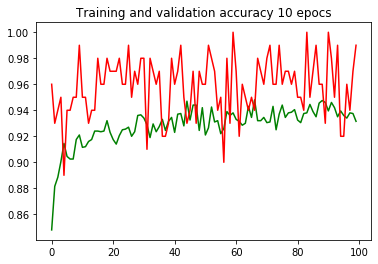

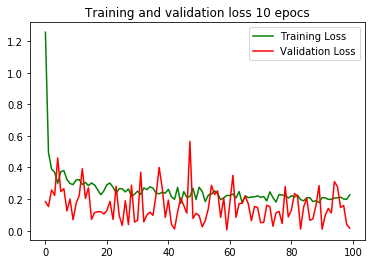

In [30]:
    
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, color='green', linestyle='solid',label='Training accuracy')
plt.plot(epochs, val_acc, color='red', linestyle='solid',  label='Validation accuracy')
plt.title('Training and validation accuracy 10 epocs')

plt.figure()

plt.plot(epochs, loss, color='green', linestyle='solid', label='Training Loss')
plt.plot(epochs, val_loss, color='red', linestyle='solid',  label='Validation Loss')
plt.title('Training and validation loss 10 epocs')
plt.legend()

plt.show()

In [33]:
model.predict(test_generator)

array([[3.1835029e-07],
       [1.8728717e-13],
       [9.9996555e-01],
       ...,
       [3.5030237e-10],
       [6.0474245e-16],
       [9.9998713e-01]], dtype=float32)

In [26]:
#import inception model
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150,150,3),# shape of our image RBG
                                include_top = False, #Leave out the last fully connected layer
                                weights = 'imagenet'
                               )
#pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable =False

87916544/87910968 [==============================] - 3s 0us/step


In [27]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = test_datagen.flow_from_directory(
        valida_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode = 'binary')

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [29]:

    history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 5,
            verbose = 2)

Epoch 1/100
100/100 - 43s - loss: 1.2562 - acc: 0.8480 - val_loss: 0.1836 - val_acc: 0.9600
Epoch 2/100
100/100 - 44s - loss: 0.4941 - acc: 0.8815 - val_loss: 0.1527 - val_acc: 0.9300
Epoch 3/100
100/100 - 45s - loss: 0.3902 - acc: 0.8885 - val_loss: 0.2584 - val_acc: 0.9400
Epoch 4/100
100/100 - 46s - loss: 0.3705 - acc: 0.9005 - val_loss: 0.2237 - val_acc: 0.9500
Epoch 5/100
100/100 - 65s - loss: 0.3002 - acc: 0.9145 - val_loss: 0.4606 - val_acc: 0.8900
Epoch 6/100
100/100 - 85s - loss: 0.3738 - acc: 0.9045 - val_loss: 0.2474 - val_acc: 0.9400
Epoch 7/100
100/100 - 42s - loss: 0.3801 - acc: 0.9025 - val_loss: 0.2658 - val_acc: 0.9400
Epoch 8/100
100/100 - 44s - loss: 0.3238 - acc: 0.9025 - val_loss: 0.1247 - val_acc: 0.9500
Epoch 9/100
100/100 - 45s - loss: 0.2988 - acc: 0.9175 - val_loss: 0.2000 - val_acc: 0.9500
Epoch 10/100
100/100 - 45s - loss: 0.2915 - acc: 0.9210 - val_loss: 0.0688 - val_acc: 0.9900
Epoch 11/100
100/100 - 46s - loss: 0.3211 - acc: 0.9115 - val_loss: 0.1742 - va

Epoch 90/100
100/100 - 50s - loss: 0.1778 - acc: 0.9460 - val_loss: 0.2860 - val_acc: 0.9300
Epoch 91/100
100/100 - 51s - loss: 0.2096 - acc: 0.9395 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 92/100
100/100 - 50s - loss: 0.2078 - acc: 0.9460 - val_loss: 0.0961 - val_acc: 0.9800
Epoch 93/100
100/100 - 49s - loss: 0.1983 - acc: 0.9420 - val_loss: 0.1409 - val_acc: 0.9500
Epoch 94/100
100/100 - 48s - loss: 0.1983 - acc: 0.9350 - val_loss: 0.1120 - val_acc: 0.9900
Epoch 95/100
100/100 - 48s - loss: 0.2063 - acc: 0.9395 - val_loss: 0.3109 - val_acc: 0.9200
Epoch 96/100
100/100 - 49s - loss: 0.2079 - acc: 0.9360 - val_loss: 0.2778 - val_acc: 0.9200
Epoch 97/100
100/100 - 49s - loss: 0.2121 - acc: 0.9340 - val_loss: 0.1468 - val_acc: 0.9600
Epoch 98/100
100/100 - 49s - loss: 0.2004 - acc: 0.9380 - val_loss: 0.1595 - val_acc: 0.9400
Epoch 99/100
100/100 - 49s - loss: 0.1985 - acc: 0.9375 - val_loss: 0.0387 - val_acc: 0.9700
Epoch 100/100
100/100 - 49s - loss: 0.2270 - acc: 0.9315 - val_loss: 0

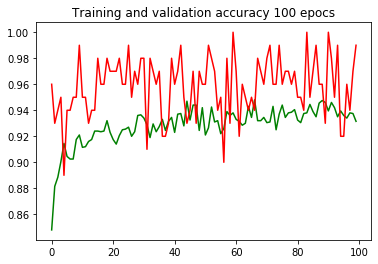

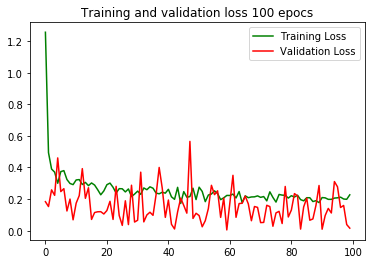

In [34]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, color='green', linestyle='solid',label='Training accuracy')
plt.plot(epochs, val_acc, color='red', linestyle='solid',  label='Validation accuracy')
plt.title('Training and validation accuracy 100 epocs')

plt.figure()

plt.plot(epochs, loss, color='green', linestyle='solid', label='Training Loss')
plt.plot(epochs, val_loss, color='red', linestyle='solid',  label='Validation Loss')
plt.title('Training and validation loss 100 epocs')
plt.legend()

plt.show()

In [32]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
model.evaluate(test_generator)

Found 2498 images belonging to 2 classes.
125/125 [==============================] - 37s 300ms/step - loss: 0.1024 - acc: 0.9696


[0.10244562476873398, 0.9695756435394287]

# The layer we will use for feature extraction in Inception v3 is called mixed7. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from mixed7:

In [35]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


# Now let's stick a fully connected classifier on top of last_output:

In [36]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)
tes_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        valida_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = tes_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


## Finally, let's train the model using the features we extracted. We'll train on all 2000 images available, for 2 epochs, and validate on all 1,000 validation images.

In [38]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/100
100/100 - 65s - loss: 0.3360 - acc: 0.8595 - val_loss: 0.1262 - val_acc: 0.9500
Epoch 2/100
100/100 - 65s - loss: 0.2279 - acc: 0.9005 - val_loss: 0.1060 - val_acc: 0.9570
Epoch 3/100
100/100 - 67s - loss: 0.2052 - acc: 0.9165 - val_loss: 0.2025 - val_acc: 0.9310
Epoch 4/100
100/100 - 67s - loss: 0.1972 - acc: 0.9295 - val_loss: 0.1597 - val_acc: 0.9440
Epoch 5/100
100/100 - 69s - loss: 0.2320 - acc: 0.9260 - val_loss: 0.1768 - val_acc: 0.9470
Epoch 6/100
100/100 - 70s - loss: 0.2201 - acc: 0.9230 - val_loss: 0.1960 - val_acc: 0.9380
Epoch 7/100
100/100 - 70s - loss: 0.2118 - acc: 0.9270 - val_loss: 0.1397 - val_acc: 0.9520
Epoch 8/100
100/100 - 70s - loss: 0.1820 - acc: 0.9305 - val_loss: 0.1385 - val_acc: 0.9460
Epoch 9/100
100/100 - 71s - loss: 0.1932 - acc: 0.9260 - val_loss: 0.1913 - val_acc: 0.9410
Epoch 10/100
100/100 - 72s - loss: 0.1673 - acc: 0.9395 - val_loss: 0.1039 - val_acc: 0.9660
Epoch 11/100
100/100 - 72s - loss: 0.1928 - acc: 0.9325 - val_loss: 0.1180 - va

Epoch 90/100
100/100 - 75s - loss: 0.1206 - acc: 0.9640 - val_loss: 0.1101 - val_acc: 0.9660
Epoch 91/100
100/100 - 75s - loss: 0.1479 - acc: 0.9510 - val_loss: 0.1522 - val_acc: 0.9720
Epoch 92/100
100/100 - 75s - loss: 0.1399 - acc: 0.9530 - val_loss: 0.1184 - val_acc: 0.9640
Epoch 93/100
100/100 - 75s - loss: 0.1772 - acc: 0.9540 - val_loss: 0.0977 - val_acc: 0.9630
Epoch 94/100
100/100 - 75s - loss: 0.1329 - acc: 0.9595 - val_loss: 0.1373 - val_acc: 0.9700
Epoch 95/100
100/100 - 75s - loss: 0.1328 - acc: 0.9545 - val_loss: 0.1267 - val_acc: 0.9710
Epoch 96/100
100/100 - 75s - loss: 0.1333 - acc: 0.9565 - val_loss: 0.1050 - val_acc: 0.9810
Epoch 97/100
100/100 - 75s - loss: 0.1752 - acc: 0.9405 - val_loss: 0.1031 - val_acc: 0.9710
Epoch 98/100
100/100 - 75s - loss: 0.1335 - acc: 0.9560 - val_loss: 0.0817 - val_acc: 0.9760
Epoch 99/100
100/100 - 75s - loss: 0.1322 - acc: 0.9515 - val_loss: 0.1633 - val_acc: 0.9640
Epoch 100/100
100/100 - 76s - loss: 0.1528 - acc: 0.9445 - val_loss: 0

# We were able to achieve a validation accuracy of % This is the kind of result we were hoping for using Transfer Learning; Building upon a pre-trained model and using it in our custom application which was able to achieve great performance after training on just 20000 images.

Plot Accuracy and Loss

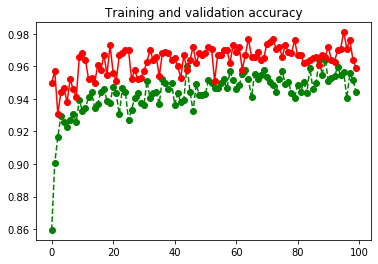

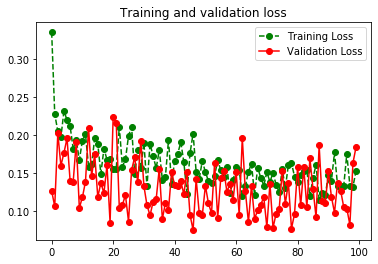

In [40]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, color='green', marker='o', linestyle='dashed',label='Training accuracy')
plt.plot(epochs, val_acc, color='red', marker='o',  label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, color='green', marker='o', linestyle='dashed', label='Training Loss')
plt.plot(epochs, val_loss, color='red', marker='o',  label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
model.evaluate(test_generator)

125/125 [==============================] - 34s 270ms/step - loss: 0.1105 - acc: 0.9712


[0.11052131652832031, 0.9711769223213196]

In [ ]:
test_dir = 'C:/Users/Mahima/Desktop/dogs-vs-cats/test1/'